In [15]:
from typing import Any, cast

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from data.attribute import YEAR_ATTR, AGE_ATTR, SEX_ATTR, SEX_MALE, SEX_FEMALE, \
    POPULATION_ATTR
from data.error import infinite_weighted_error_margin
from data.selects.columns import RESPONDENT_ID, TOTAL_WEIGHT, SELECTS_DEMOGRAPHIC_COLUMNS
from data.selects.process import post_process_selects
from utils.distribution import total_variance_distance

In [2]:
from data.selects.source import get_fors_selects
from data.population import get_bfs_population_cga

selects_df = get_fors_selects()
population_df = get_bfs_population_cga()

In [4]:
from data.population import get_electorate

year = selects_df[YEAR_ATTR].max()
electorate_year_df = get_electorate(population_df[population_df[YEAR_ATTR] == year])
raw_selects_year_df = selects_df[selects_df[YEAR_ATTR] == year].dropna(axis=1, how='all')
selects_year_df = post_process_selects(raw_selects_year_df, electorate_year_df)

print(f'Year: {year}')

Year: 2019


In [5]:
from pandas.core.groupby import DataFrameGroupBy


def mean_participation(selects: pd.DataFrame) -> pd.Series:
    has_participated = selects['vp1'] == 'yes'
    weights_sum = selects[TOTAL_WEIGHT].sum()
    if weights_sum == 0:
        return pd.Series({'Value': np.nan, 'Error': np.nan})
    return pd.Series({
        'Value': (has_participated * selects[TOTAL_WEIGHT]).sum() / weights_sum,
        'Error': infinite_weighted_error_margin(has_participated, selects[TOTAL_WEIGHT], selects[RESPONDENT_ID]),
    }, name='Participation')


def mean_interest(selects: pd.DataFrame) -> float:
    weights_sum = selects[TOTAL_WEIGHT].sum()
    interest = selects['pi1'].copy().cat.add_categories(['na']).fillna('na')
    return 0 if weights_sum == 0 else selects[TOTAL_WEIGHT].groupby(interest, observed=False).sum() / weights_sum


def get_mean_participation(group_by: DataFrameGroupBy) -> pd.DataFrame:
    return cast(pd.DataFrame, group_by.apply(mean_participation, include_groups=False))


def get_mean_interest(group_by: DataFrameGroupBy) -> pd.Series:
    return cast(pd.Series, group_by.apply(mean_interest, include_groups=False))


def get_population_ration(group_by: DataFrameGroupBy) -> pd.Series:
    population = group_by[TOTAL_WEIGHT].sum()
    population /= population.sum()
    return population


def describe_participation_extremes(series: pd.Series):
    """Print the lowest and highest participation values in a series."""
    attr_name = ' / '.join(map(str, series.index.names)) \
        if isinstance(series.index, pd.MultiIndex) else \
        series.index.name
    print(f"Participation Extremes by {attr_name}:")

    minimum, maximum = series.min(), series.max()
    min_idx = series.idxmin()
    max_idx = series.idxmax()
    min_label = ' / '.join(str(x) for x in min_idx) if isinstance(min_idx, tuple) else min_idx
    max_label = ' / '.join(str(x) for x in max_idx) if isinstance(max_idx, tuple) else max_idx
    print(f'  Lowest ({min_label}): {minimum * 100:0.2f}% ({minimum / maximum:0.2f}x of highest)')
    print(f'  Highest ({max_label}): {maximum * 100:0.2f}% ({maximum / minimum:0.2f}x of lowest)')


def plot_attribute(attr: Any, group_by: DataFrameGroupBy):
    participation = get_mean_participation(group_by)
    population = group_by[TOTAL_WEIGHT].sum()
    population /= population.sum()
    interest = group_by.apply(mean_interest, include_groups=False)

    fig = plt.figure(figsize=(12, 5))
    fig.suptitle(f'Demographics by {attr}')
    grid = fig.add_gridspec(2, 2)
    plot_participation(
        participation, ax=fig.add_subplot(grid[0, 0]),
        # Already labeled on the population plot
        xticks=[], xlabel=''
    )
    plot_population(
        population,
        ax=fig.add_subplot(grid[1, 0]),
        xlabel=attr,
    )
    plot_interest_single(
        interest, ax=fig.add_subplot(grid[:, 1]),
        participation=participation,
        rot=90, xlabel=attr,
    )


def plot_interest_single(interest: pd.Series, *, participation: pd.Series = None, ax: plt.Axes = None, **kwargs):
    ax = interest.plot(
        kind='bar', stacked=True, ylim=(0, 1),
        title='Political Interest',
        ylabel='Proportion',
        ax=ax,
    )
    participation['Value'].plot(
        marker='.', linestyle='none', color='black', ax=ax,
        # Last plot call, so will overwrite previous axis settings
        **kwargs
    )
    ax.legend(title='Political Interest', loc='center left', bbox_to_anchor=(1, 0.5))
    return ax


def plot_interest_multiple(interest: pd.DataFrame, **kwargs):
    return interest.plot(
        kind='bar',
        title='Political Interest',
        ylabel='Proportion',
        yerr=interest,
        **kwargs
    )


def _maybe_label_bars(ax: plt.Axes, values: pd.Series | pd.DataFrame):
    if (not isinstance(values, pd.Series) and len(values.columns) > 1) or len(values) > 10:
        return
    for i, v in enumerate(values):
        ax.text(i, v + 0.02, f'{v:.2f}', ha='center')


def plot_participation(
        participation: pd.DataFrame, *,
        title: str = 'Participation',
        **kwargs
):
    ax = participation['Value'].plot(
        kind='bar',
        title=title,
        yerr=participation['Error'],
        **kwargs
    )
    ax.axhline(REAL_2019_TURNOUT, color='red', ls='--')
    _maybe_label_bars(ax, participation['Value'])
    if isinstance(participation.columns, pd.MultiIndex):
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    return ax


def plot_population(
        population: pd.Series | pd.DataFrame, title: str = 'Population', **kwargs
):
    ax = population.plot(kind='bar', title=title, **kwargs)
    _maybe_label_bars(ax, population)
    return ax


def format_uncertain_value(value: float, error_margin: float) -> str:
    return f"{value:.3f}±{error_margin:.3f}"

In [8]:
REAL_2019_TURNOUT = 0.451
print(f'Selects turnout: {format_uncertain_value(*mean_participation(selects_year_df))}')
print(f'Raw selects turnout: {format_uncertain_value(*mean_participation(raw_selects_year_df))}')
print(f'BFS turnout: {REAL_2019_TURNOUT:.3f}')


def _correct_participation(selects: pd.DataFrame) -> pd.DataFrame:
    turnout = mean_participation(selects)['Value']
    corrected = selects.copy()
    voted_mask = corrected['vp1'] == 'yes'
    corrected.loc[voted_mask, TOTAL_WEIGHT] *= REAL_2019_TURNOUT / turnout
    corrected.loc[~voted_mask, TOTAL_WEIGHT] *= (1 - REAL_2019_TURNOUT) / (1 - turnout)
    return corrected


corrected_selects_year_df = _correct_participation(selects_year_df)
corrected_raw_selects_year_df = _correct_participation(raw_selects_year_df)
print(f'Corrected selects turnout: {format_uncertain_value(*mean_participation(corrected_selects_year_df))}')
print(f'Corrected raw selects turnout: {format_uncertain_value(*mean_participation(corrected_raw_selects_year_df))}')

Selects turnout: 0.455±0.018
Raw selects turnout: 0.447±0.018
BFS turnout: 0.451
Corrected selects turnout: 0.451±0.018
Corrected raw selects turnout: 0.451±0.018


Participation Extremes by pi1:
  Lowest (not interested at all): 6.45% (0.08x of highest)
  Highest (very interested): 83.29% (12.91x of lowest)


<Axes: title={'center': 'Population Distribution by Political Interest'}, xlabel='pi1', ylabel='Portion'>

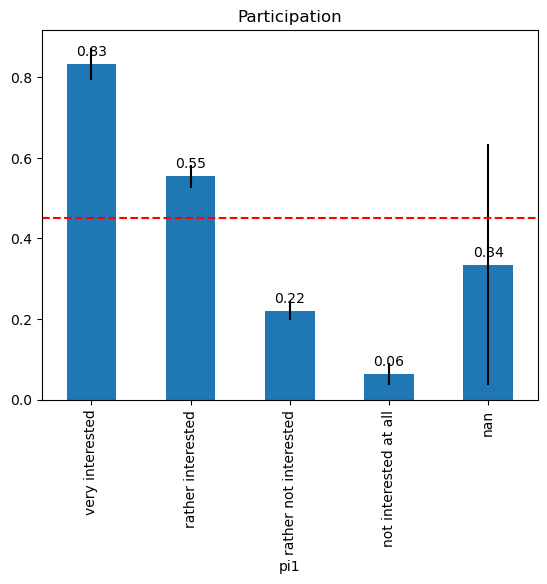

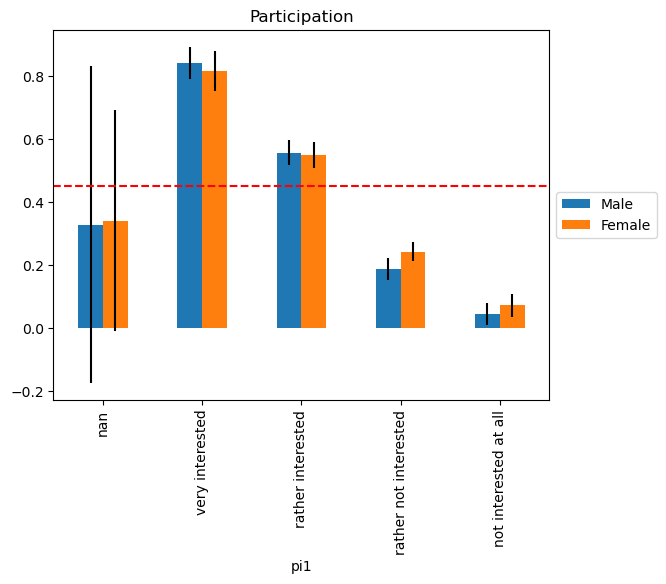

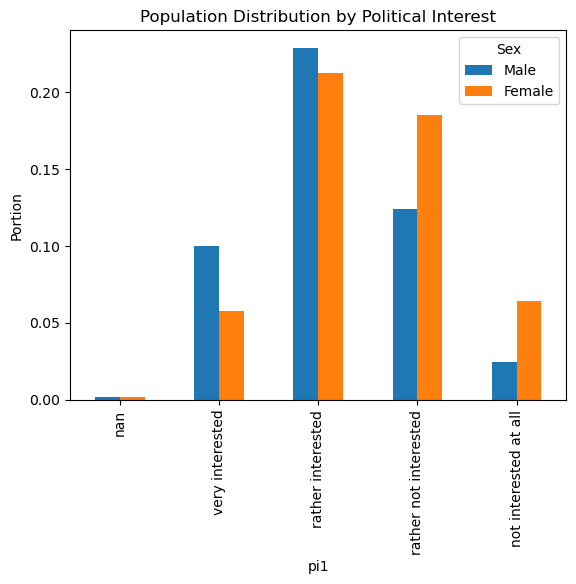

In [30]:
interest_participation = get_mean_participation(corrected_selects_year_df.groupby('pi1', dropna=False, observed=False))
interest_sex_participation = get_mean_participation(
    corrected_selects_year_df.groupby([SEX_ATTR, 'pi1'], dropna=False, observed=False)
).unstack(level=SEX_ATTR)
interest_sex_population = get_population_ration(
    corrected_selects_year_df.groupby([SEX_ATTR, 'pi1'], dropna=False, observed=False)
).unstack(level=SEX_ATTR)

describe_participation_extremes(interest_participation['Value'])
plot_participation(interest_participation)
plot_participation(interest_sex_participation)
interest_sex_population.plot(
    kind='bar',
    title='Population Distribution by Political Interest',
    ylabel='Portion'
)

Participation Extremes by pk6:
  Lowest (low knowledge): 14.41% (0.17x of highest)
  Highest (high knowledge): 85.39% (5.93x of lowest)


<Axes: title={'center': 'Participation'}, xlabel='pk6'>

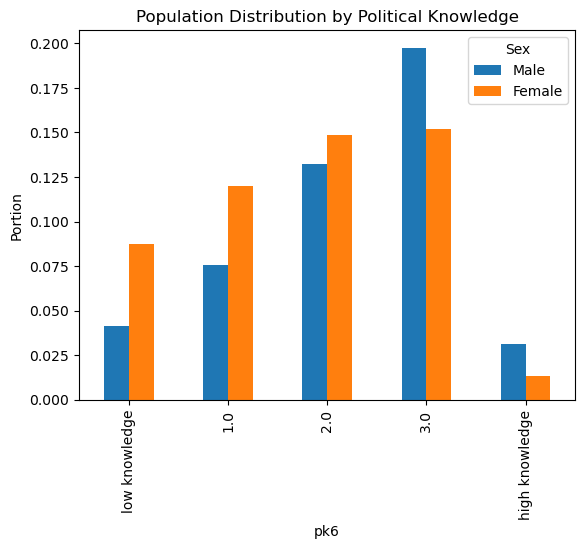

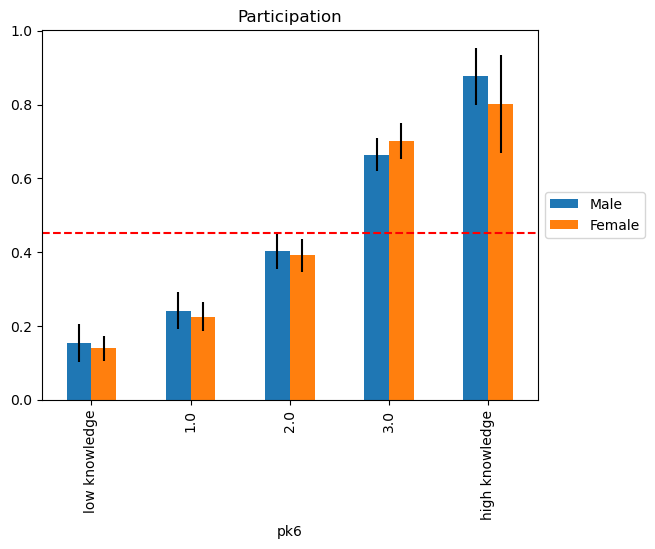

In [10]:
describe_participation_extremes(
    get_mean_participation(corrected_selects_year_df.groupby('pk6', observed=True, dropna=False))['Value']
)

knowledge_sex_grouping = corrected_selects_year_df.groupby([SEX_ATTR, 'pk6'], observed=True, dropna=False)
get_population_ration(knowledge_sex_grouping).unstack(level=SEX_ATTR).plot(
    kind='bar',
    title='Population Distribution by Political Knowledge',
    ylabel='Portion'
)
plot_participation(get_mean_participation(knowledge_sex_grouping).unstack(level=SEX_ATTR))

In [17]:
# Get all possible attributes to analyze
attributes = [
    col for col in corrected_selects_year_df.columns
    if col in SELECTS_DEMOGRAPHIC_COLUMNS or col in (
        'vp2',  # Participated 4 years ago
        'hvdn2b',  # National council real or hypothetical voting decision
    )
]

# Analyze each attribute
attribute_metrics = []
attribute_groupings = {}
for attribute in attributes:
    series = corrected_selects_year_df[attribute]

    # Determine what to group by
    unique_count = series.nunique(dropna=False)
    if unique_count <= 20 or isinstance(series.dtype, pd.CategoricalDtype):
        group_attr = attribute
    elif pd.api.types.is_numeric_dtype(series):
        group_attr = pd.cut(series, bins=12)
    else:
        print(
            f'Skipping "{attribute}". '
            f'Attribute has too many unique values ({unique_count}) '
            f'and is not numeric ({series.dtype}).'
        )
        continue

    # Create grouping
    grouping = attribute_groupings[attribute] = corrected_selects_year_df \
        .groupby(group_attr, observed=True, dropna=False)
    group_participation = get_mean_participation(grouping)
    group_size = grouping[TOTAL_WEIGHT].sum()
    group_participants_size = group_size * group_participation['Value']

    # Calculate metrics
    min_participation = group_participation['Value'].min()
    max_participation = group_participation['Value'].max()
    attribute_metrics.append({
        'attribute': attribute,
        'min_participation': min_participation,
        'max_participation': max_participation,
        'max_min_ratio': max_participation / min_participation if min_participation > 0 else np.nan,
        # Compare electorate with participants distributions to take into account electorate non-uniformity
        'participation_uniformity': total_variance_distance(group_size, group_participants_size),
        'population_uniformity': total_variance_distance(group_size, np.full_like(group_size, 1 / len(group_size))),
        'valid_proportion': series.count() / len(series),
        'group_count': grouping.ngroups,
        'is_numeric': pd.api.types.is_numeric_dtype(series),
    })
metrics_df = pd.DataFrame(attribute_metrics).set_index('attribute') \
    .sort_values('participation_uniformity', ascending=False)

metrics_df

,min_participation,max_participation,max_min_ratio,participation_uniformity,population_uniformity,valid_proportion,group_count,is_numeric
attribute,,,,,,,,
vp2,0.177293,0.743049,4.191087,0.296184,0.424407,0.993458,4,False
hvdn2b,0.053736,0.863054,16.060986,0.126023,0.475723,0.910839,17,False
income3,0.262323,0.552249,2.105227,0.122162,0.392211,0.977979,4,False
ses1,0.355118,0.548419,1.544326,0.106259,0.462132,0.985806,4,False
educ,0.264615,0.586588,2.216763,0.092268,0.367941,0.977562,10,False
Age,0.320931,0.598686,1.865469,0.089520,0.175808,1.000000,12,True
sch1,0.190487,0.726325,3.812994,0.086359,0.592685,0.962831,10,False
income_hh,0.334805,0.544033,1.624924,0.079823,0.096913,0.663867,6,False
class8,0.327033,0.641547,1.961722,0.077952,0.152826,0.866823,9,False


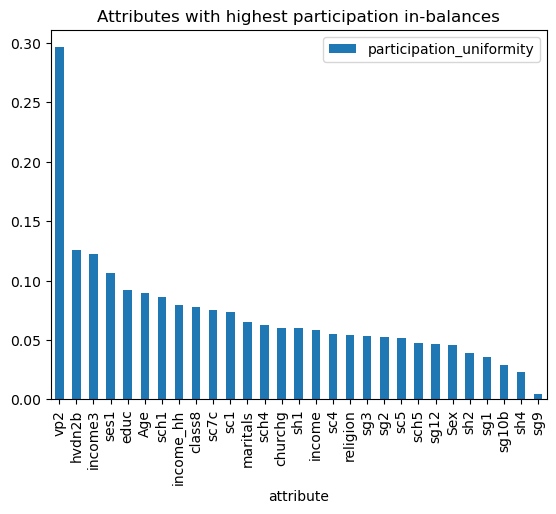

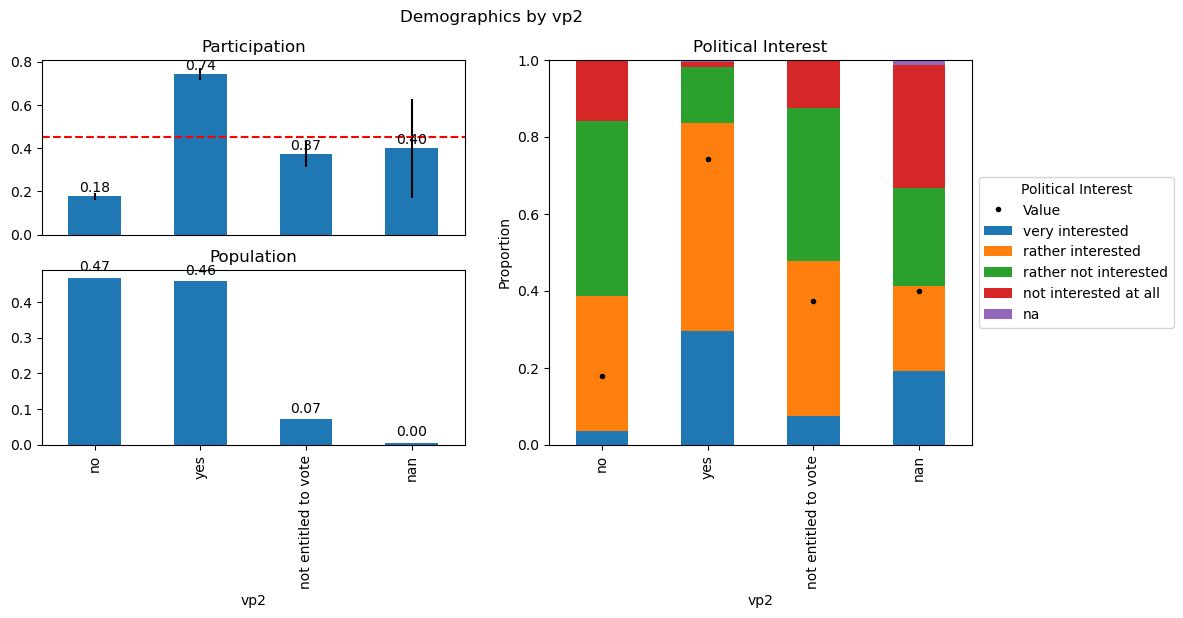

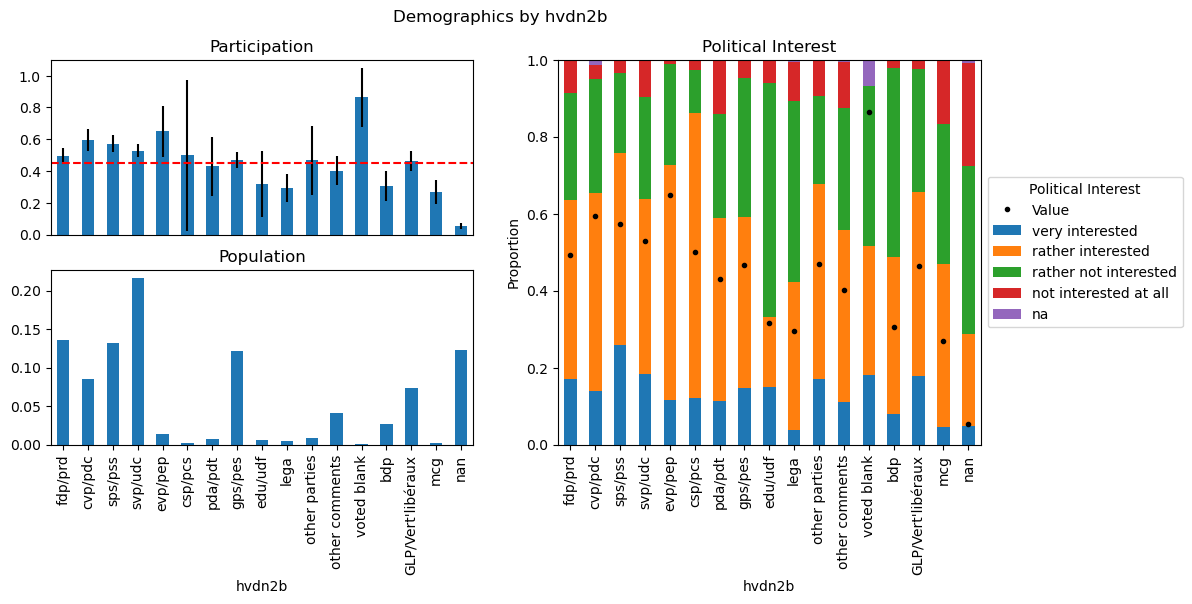

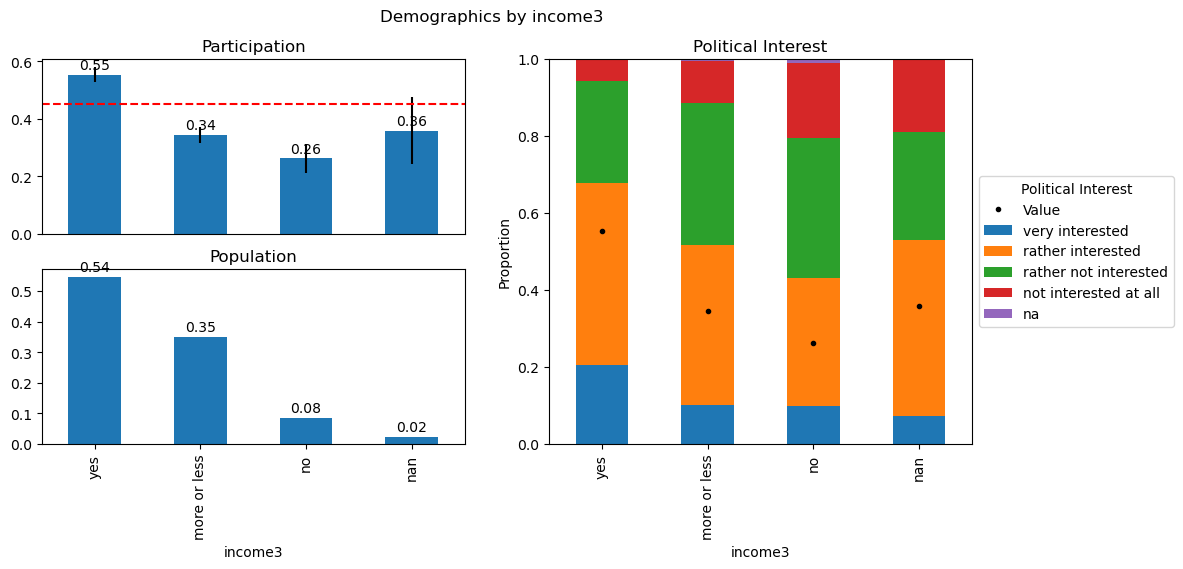

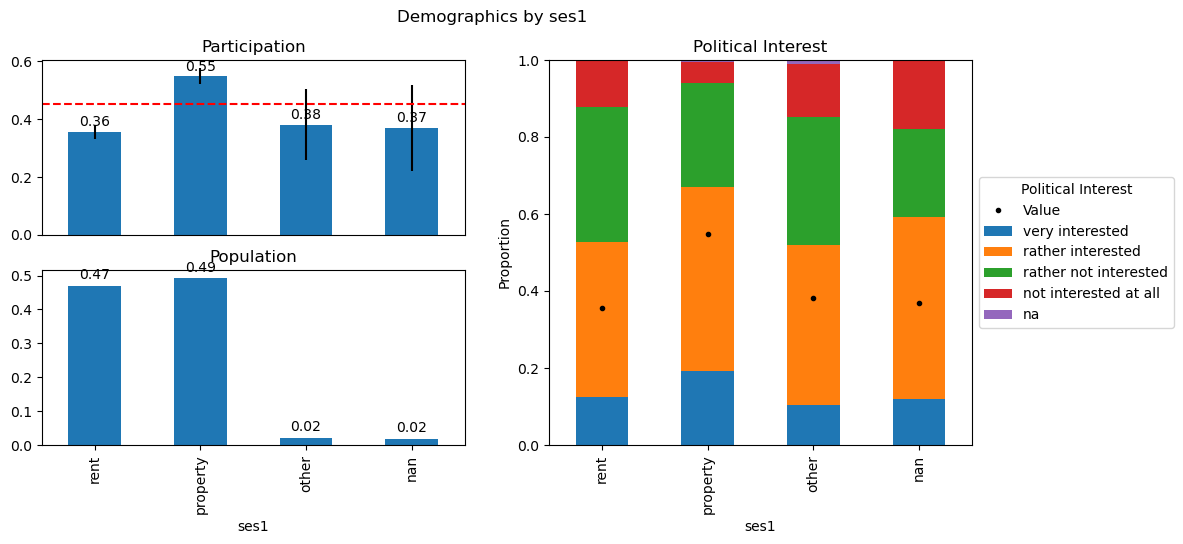

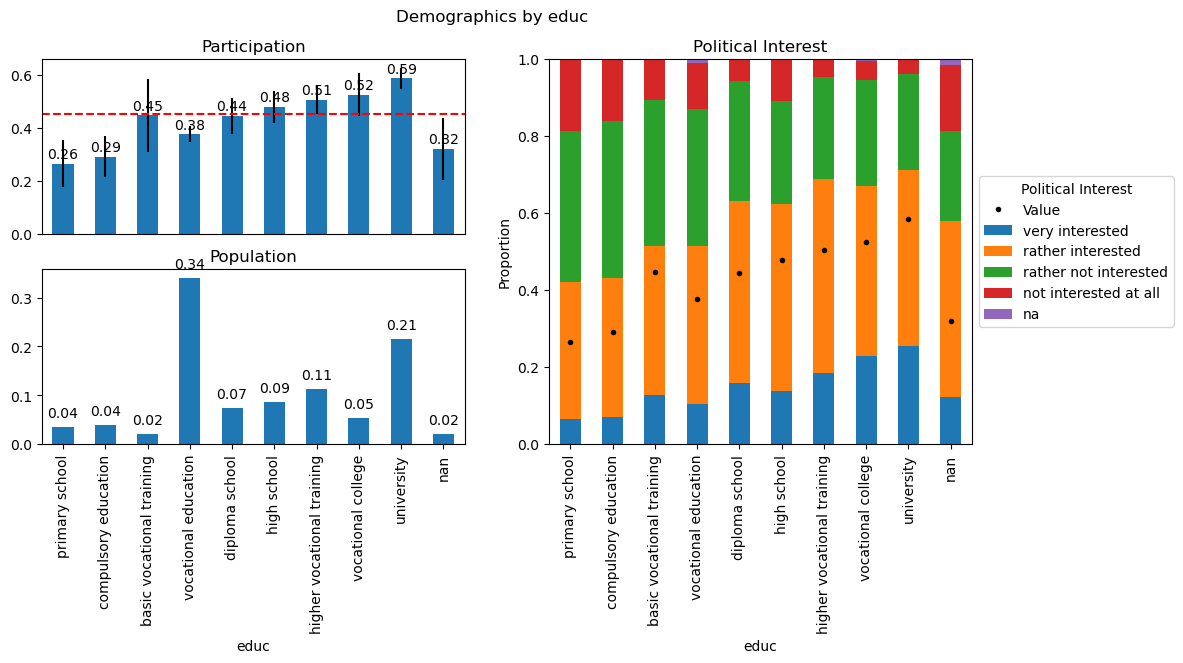

In [18]:
analyze_candidates = metrics_df[metrics_df['valid_proportion'] > 0.5]
analyze_candidates.plot(
    y='participation_uniformity', kind='bar',
    title='Attributes with highest participation in-balances'
)
plt.show()

for attribute, metrics in analyze_candidates.head(5).iterrows():
    plot_attribute(attribute, attribute_groupings[attribute])

Participation Extremes by Sex:
  Lowest (Female): 42.63% (0.89x of highest)
  Highest (Male): 47.93% (1.12x of lowest)


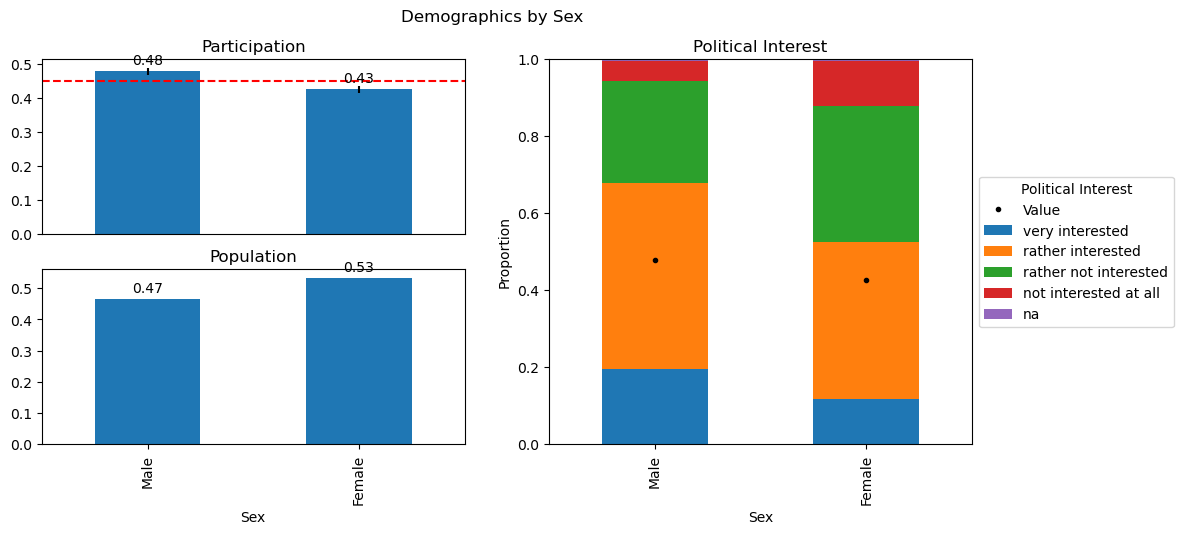

In [10]:
sex_grouping = corrected_selects_year_df.groupby(SEX_ATTR, observed=False)
plot_attribute(SEX_ATTR, sex_grouping)
describe_participation_extremes(get_mean_participation(sex_grouping)['Value'])

In [19]:
# Group very old people into a single group because of their small sample size
MAX_AGE = 90
age_grouping = corrected_selects_year_df[AGE_ATTR].clip(upper=MAX_AGE)
age_electorate = electorate_year_df.groupby(electorate_year_df[AGE_ATTR].clip(upper=MAX_AGE))[POPULATION_ATTR].sum()

Participation Extremes by Age:
  Lowest (27): 31.35% (0.51x of highest)
  Highest (72): 61.14% (1.95x of lowest)
Participation Extremes by Age / Sex:
  Lowest (28 / Female): 29.60% (0.41x of highest)
  Highest (71 / Male): 72.51% (2.45x of lowest)


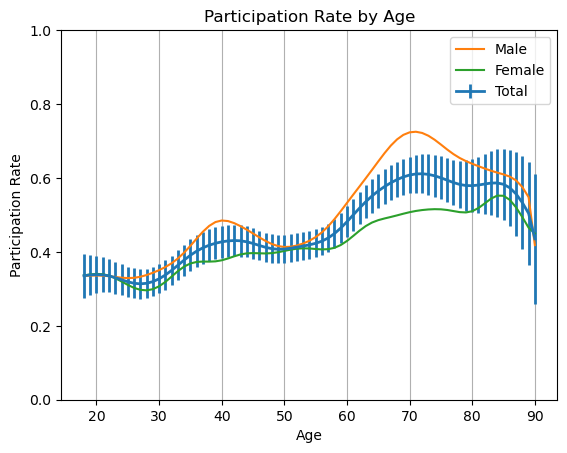

In [20]:
age_sex_participation = corrected_selects_year_df.groupby([age_grouping, SEX_ATTR], dropna=False, observed=True) \
    .apply(mean_participation, include_groups=False)
age_participation = corrected_selects_year_df.groupby(age_grouping).apply(mean_participation)

ax = age_participation['Value'].rename('Total').plot(linewidth=2, yerr=age_participation['Error'])
age_sex_participation['Value'].unstack(level=SEX_ATTR).plot(
    ylim=(0, 1),
    title='Participation Rate by Age',
    ylabel='Participation Rate',
    grid=True,
    ax=ax
)
ax.grid(axis='y')
ax.legend()

describe_participation_extremes(age_participation['Value'])
describe_participation_extremes(age_sex_participation['Value'])

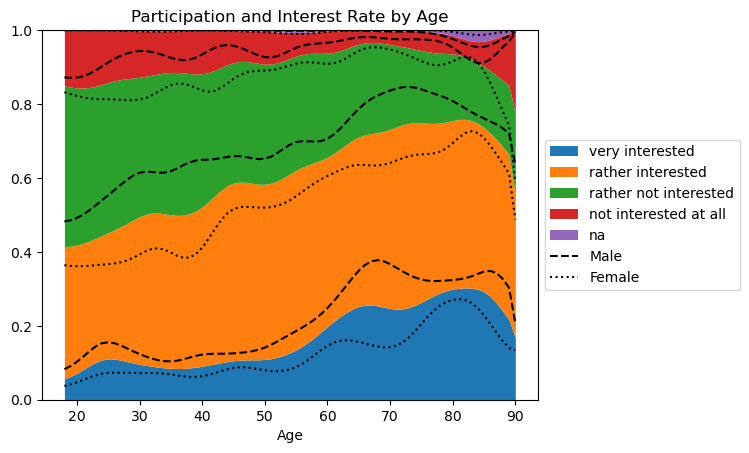

In [21]:
_SEX_LINE_STYLE = {
    SEX_MALE: '--',
    SEX_FEMALE: ':'
}

age_interest = corrected_selects_year_df.groupby(age_grouping).apply(mean_interest)
age_sex_interest = corrected_selects_year_df.groupby([age_grouping, SEX_ATTR], dropna=False, observed=True) \
    .apply(mean_interest, include_groups=False).unstack(level=SEX_ATTR)
available_sex = corrected_selects_year_df[SEX_ATTR].unique()

ax = age_interest.plot(
    kind='area', stacked=True, linewidth=0,
    title='Participation and Interest Rate by Age',
    ylim=(0, 1)
)
for sex in available_sex:
    age_sex_interest.xs(sex, level=SEX_ATTR, axis=1) \
        .plot(color='black', linestyle=_SEX_LINE_STYLE[sex], stacked=True, ax=ax)

# Modify the legend to show the correct labels
handles, labels = ax.get_legend_handles_labels()
area_handles = handles[:len(age_interest.columns)]  # Area plot handles
sex_handles = [
    handles[len(area_handles) + i * len(age_interest.columns)]
    for i in range(len(age_sex_interest.columns.get_level_values(SEX_ATTR).unique()))
]
ax.legend(
    area_handles + sex_handles,
    labels[:len(age_interest.columns)] + list(available_sex),
    loc='center left', bbox_to_anchor=(1, 0.5)
)

Participation Extremes by sg3:
  Lowest (24): 28.43% (0.38x of highest)
  Highest (14): 75.12% (2.64x of lowest)


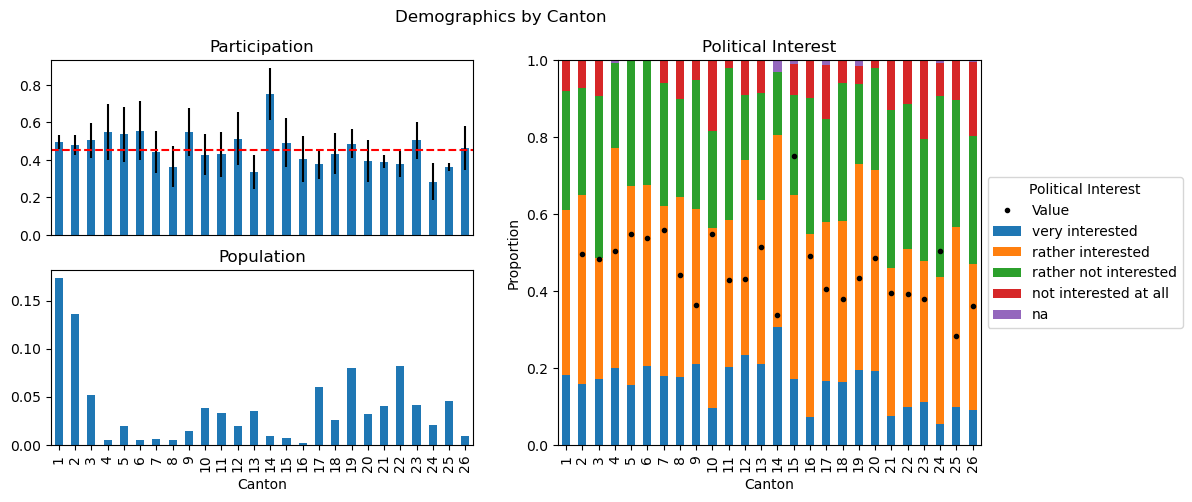

In [22]:
# TODO: Compare and correct with ground truth
canton_grouping = corrected_selects_year_df.groupby('sg3', observed=True)
plot_attribute('Canton', canton_grouping)
describe_participation_extremes(get_mean_participation(canton_grouping)['Value'])

<Axes: title={'center': 'Participation'}>

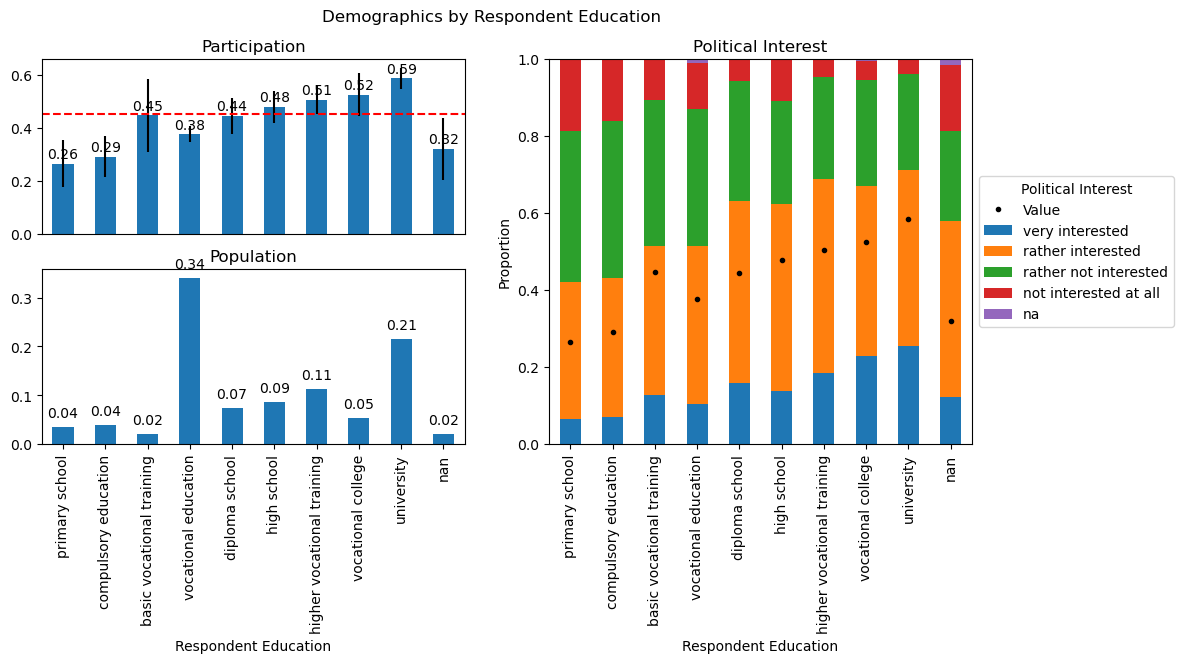

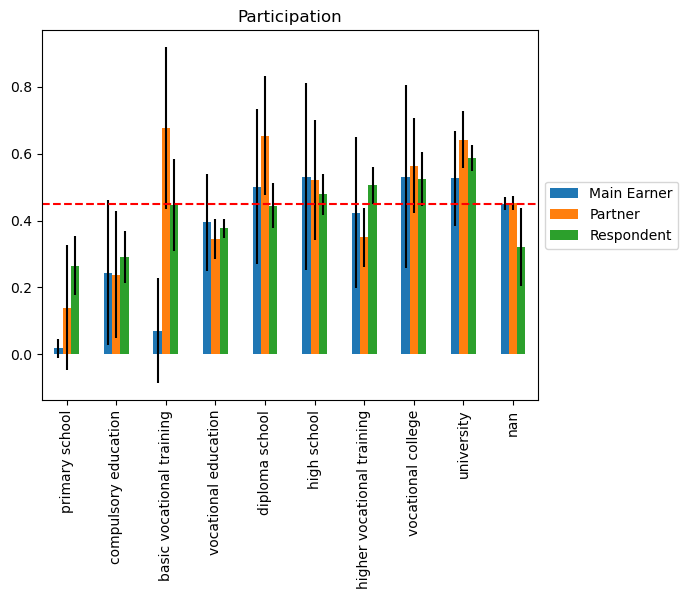

In [24]:
education_grouping = corrected_selects_year_df.groupby('educ', observed=True, dropna=False)
plot_attribute('Respondent Education', education_grouping)
plot_participation(
    pd.concat({
        'Main Earner': get_mean_participation(corrected_selects_year_df.groupby('educh', observed=True, dropna=False)),
        'Partner': get_mean_participation(corrected_selects_year_df.groupby('educp', observed=True, dropna=False)),
        'Respondent': get_mean_participation(education_grouping),
    }, axis=1).swaplevel(axis=1)
)

Participation Extremes by sc1:
  Lowest (unemployed): 21.53% (0.37x of highest)
  Highest (retired): 58.77% (2.73x of lowest)


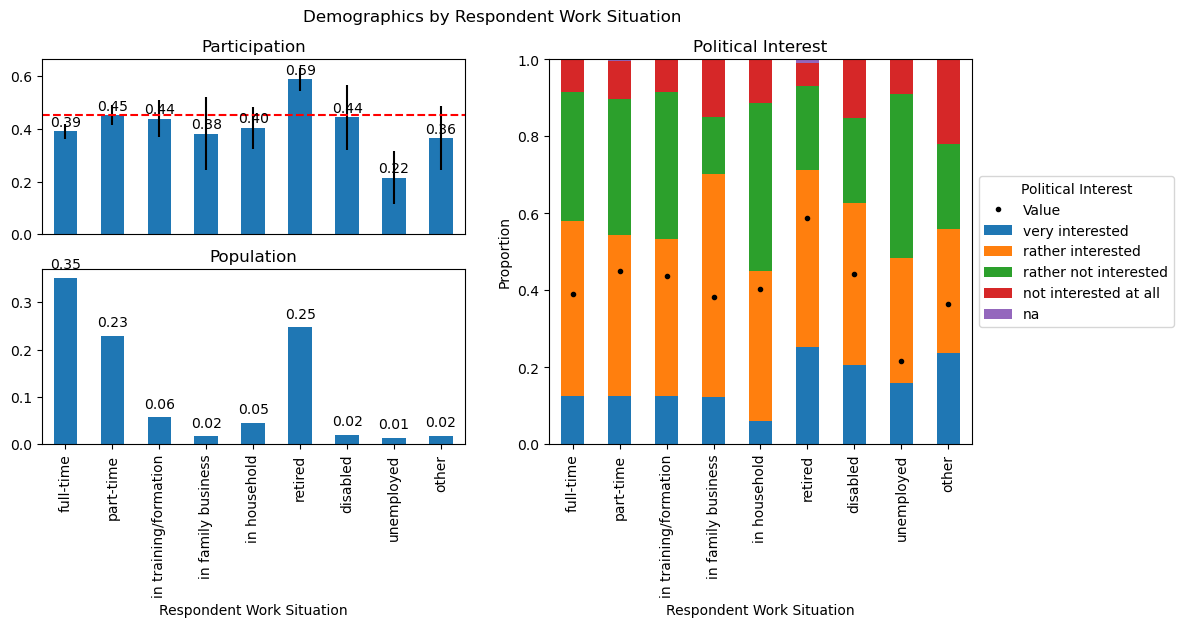

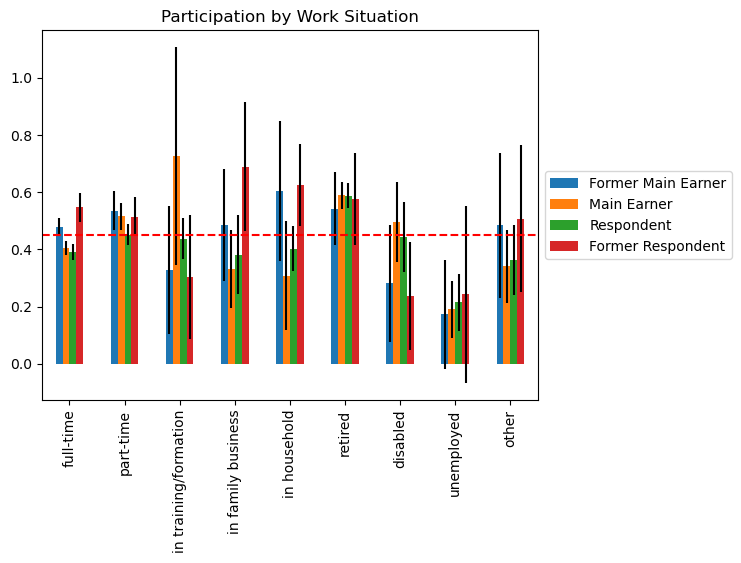

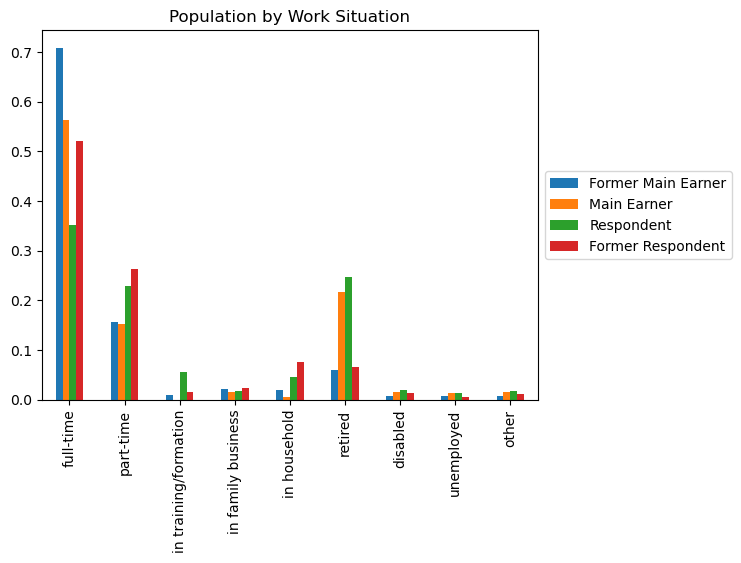

In [25]:
work_situation_grouping = corrected_selects_year_df.groupby('sc1', observed=True)
work_situation_participation = get_mean_participation(work_situation_grouping)
former_work_situation_grouping = corrected_selects_year_df.groupby('sc1a', observed=True)
main_earner_work_situation_grouping = corrected_selects_year_df.groupby('sch1', observed=True)
former_main_earner_work_situation_grouping = corrected_selects_year_df.groupby('sch1a', observed=True)

describe_participation_extremes(work_situation_participation['Value'])
plot_attribute('Respondent Work Situation', work_situation_grouping)
ax = plot_participation(
    pd.concat({
        'Former Main Earner': get_mean_participation(former_main_earner_work_situation_grouping),
        'Main Earner': get_mean_participation(main_earner_work_situation_grouping),
        'Respondent': work_situation_participation,
        'Former Respondent': get_mean_participation(former_work_situation_grouping),
    }, axis=1).swaplevel(axis=1),
    title='Participation by Work Situation',
)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax = plot_population(
    pd.concat([
        get_population_ration(former_main_earner_work_situation_grouping).rename('Former Main Earner'),
        get_population_ration(main_earner_work_situation_grouping).rename('Main Earner'),
        get_population_ration(work_situation_grouping).rename('Respondent'),
        get_population_ration(former_work_situation_grouping).rename('Former Respondent'),
    ], axis=1),
    title='Population by Work Situation',
)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

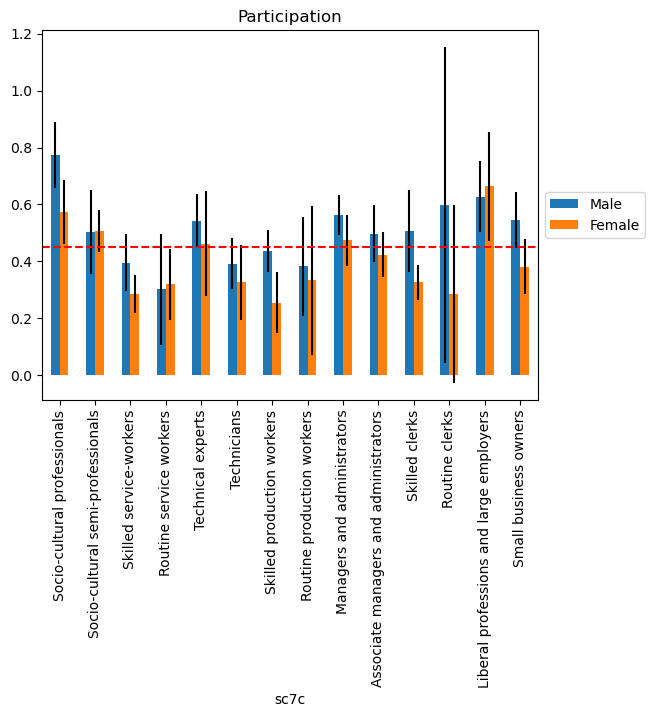

Participation Extremes by sc7c:
  Lowest (Routine service workers): 31.46% (0.48x of highest)
  Highest (Socio-cultural professionals): 65.83% (2.09x of lowest)
Participation Extremes by Sex / sc7c:
  Lowest (Female / Skilled production workers): 25.47% (0.33x of highest)
  Highest (Male / Socio-cultural professionals): 77.32% (3.04x of lowest)


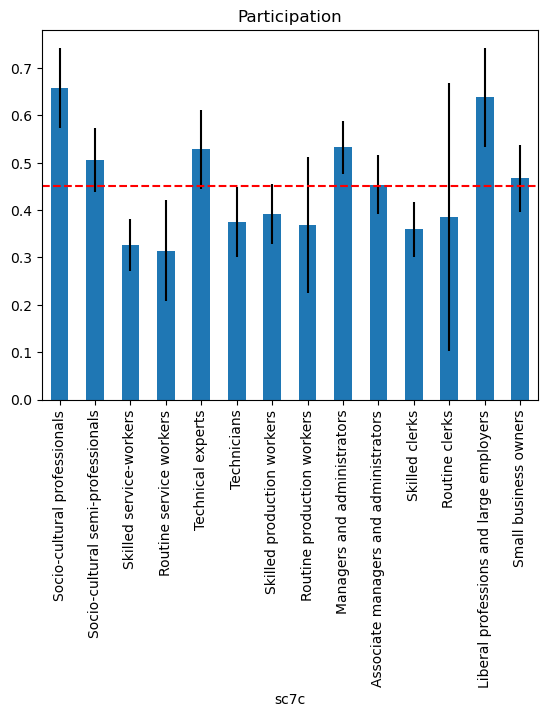

In [26]:
social_class_participation = get_mean_participation(corrected_selects_year_df.groupby('sc7c', observed=True))
social_class_sex_participation = get_mean_participation(
    corrected_selects_year_df.groupby([SEX_ATTR, 'sc7c'], observed=True))

plot_participation(social_class_sex_participation.unstack(level=SEX_ATTR))
plt.show()
plot_participation(social_class_participation)

describe_participation_extremes(social_class_participation['Value'])
describe_participation_extremes(social_class_sex_participation['Value'])

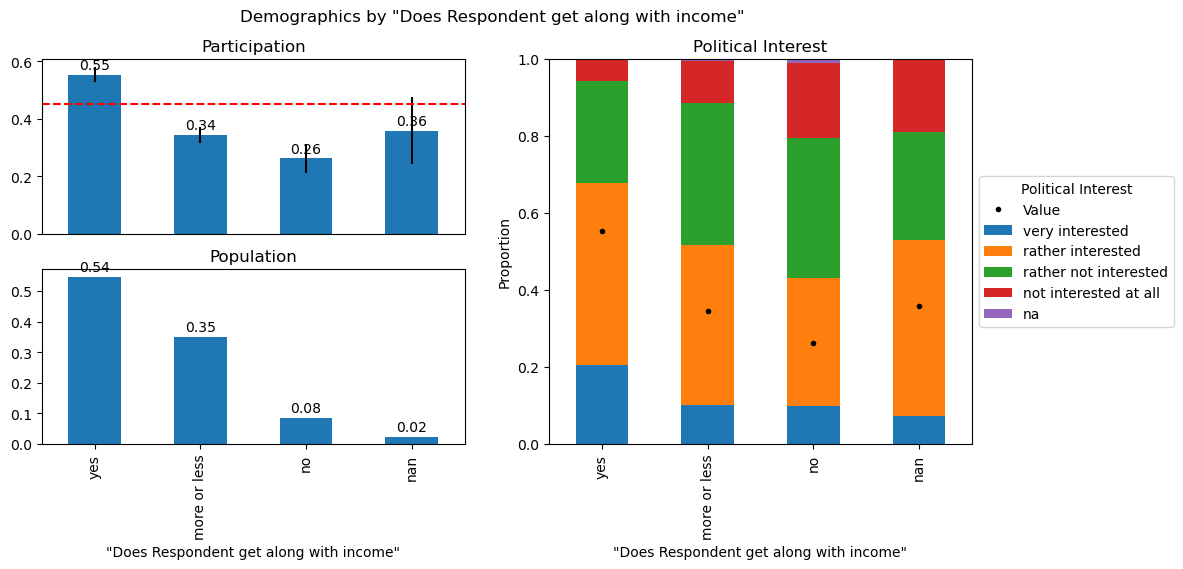

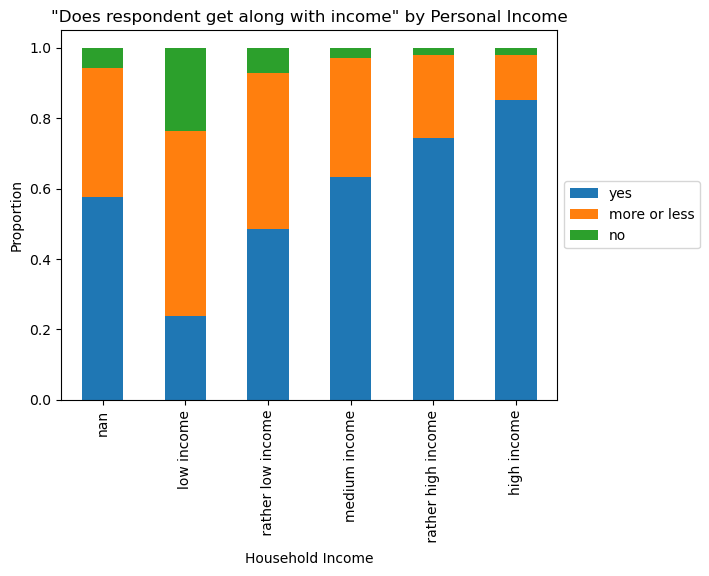

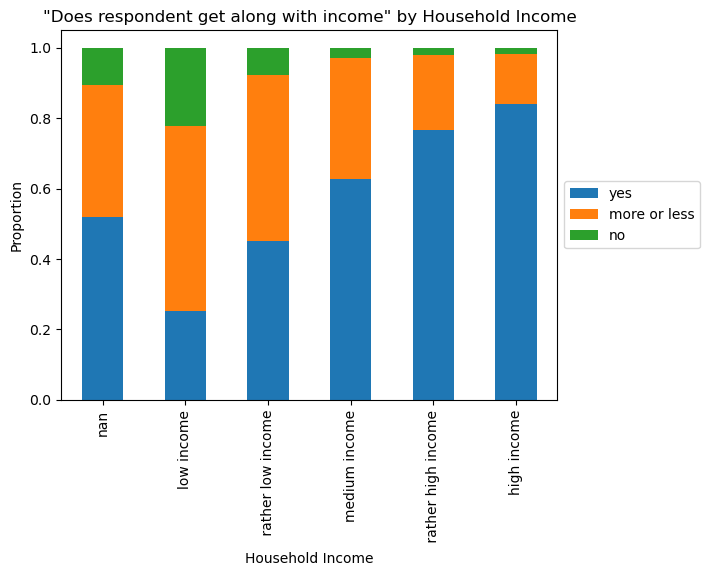

In [27]:
def _plot_income3_distribution(attribute: Any, attribute_name: str):
    income_distribution = pd.crosstab(
        corrected_selects_year_df[attribute],
        corrected_selects_year_df['income3'],
        values=corrected_selects_year_df[TOTAL_WEIGHT],
        aggfunc='sum',
        normalize='index',
        dropna=False
    )
    ax = income_distribution.plot(
        kind='bar',
        stacked=True,
        title=f'"Does respondent get along with income" by {attribute_name}',
        ylabel='Proportion',
        xlabel='Household Income'
    )
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


plot_attribute(
    '"Does Respondent get along with income"',
    corrected_selects_year_df.groupby('income3', observed=True, dropna=False)
)
_plot_income3_distribution('income', 'Personal Income')
_plot_income3_distribution('income_hh', 'Household Income')